# Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [2]:
entries = pd.read_csv("entries_processed.csv")[["Entry_Date", "Stemmed_Entry"]]
tutanak = pd.read_csv("tutanak_processed.csv")[["Date", "Stemmed_Transcript"]]

entries = entries.sort_values("Entry_Date").reset_index(drop=True)
tutanak = tutanak.sort_values("Date").reset_index(drop=True)

entries = entries.dropna().reset_index(drop=True)
tutanak = tutanak.dropna().reset_index(drop=True)

In [3]:
dates = sorted(tutanak["Date"].unique())
dates = ["2021-11-01"] + dates

## Analysis

In [4]:
def word_freq(column):
    
    words = []
    for item in column:
        for word in item.split():
            words.append(word)
            
    df = pd.concat([pd.Series(list(dict(Counter(words)).keys()), name="word"),
                    pd.Series(list(dict(Counter(words)).values()), name="counts")], axis=1)
    
    df["freq"] = df["counts"] / df["counts"].sum()
    
    return df[["word", "freq"]].sort_values("freq", ascending=False).reset_index(drop=True)

$\text{incongruency level} = \frac{\sum_{i=1}^N|{x_{1i} - x_{2i}|}}{N}$

In [5]:
def congruency(start_date, end_date):
    
    entries_df = entries[(entries["Entry_Date"] >= start_date) & (entries["Entry_Date"] < end_date)].reset_index(drop=True)
    tutanak_df = tutanak[tutanak["Date"] == end_date]
    
    freq_df = pd.merge(word_freq(entries_df["Stemmed_Entry"]),
                       word_freq(tutanak_df["Stemmed_Transcript"]),
                       on="word").rename({"freq_x": "entry_freq", "freq_y": "transcript_freq"},axis=1)
    
    return np.abs(freq_df["entry_freq"] - freq_df["transcript_freq"]).mean()

In [6]:
congruencies = []
start_dates = []
end_dates = []

for i in range(len(dates)-1):
    start_date = dates[i]
    start_dates.append(start_date)
    end_date = dates[i+1]
    end_dates.append(end_date)
    congruencies.append(congruency(start_date, end_date))

In [7]:
congruency_df = pd.DataFrame([start_dates, end_dates, congruencies]).T.rename({0: "Start_Date", 1: "End_Date", 2: "Congruency"}, axis=1)

congruency_df["Start_Date"] = pd.to_datetime(congruency_df["Start_Date"])
congruency_df["End_Date"] = pd.to_datetime(congruency_df["End_Date"])
congruency_df["Congruency_avg"] = [congruency_df["Congruency"][i] / (congruency_df["End_Date"][i] - congruency_df["Start_Date"][i]).days for i in range(len(congruency_df))]
congruency_df["Date"] = congruency_df["End_Date"].astype(str).apply(lambda x: x[5:])

In [8]:
congruency_df

,Start_Date,End_Date,Congruency,Congruency_avg,Date
0,2021-11-01,2021-11-02,0.000842,0.000842,11-02
1,2021-11-02,2021-11-03,0.000795,0.000795,11-03
2,2021-11-03,2021-11-04,0.000683,0.000683,11-04
3,2021-11-04,2021-11-09,0.005015,0.001003,11-09
4,2021-11-09,2021-11-10,0.000555,0.000555,11-10
5,2021-11-10,2021-11-11,0.000627,0.000627,11-11
6,2021-11-11,2021-11-16,0.000242,0.000048,11-16
7,2021-11-16,2021-11-17,0.00016,0.000160,11-17
8,2021-11-17,2021-11-18,0.000166,0.000166,11-18
9,2021-11-18,2021-11-23,0.000142,0.000028,11-23


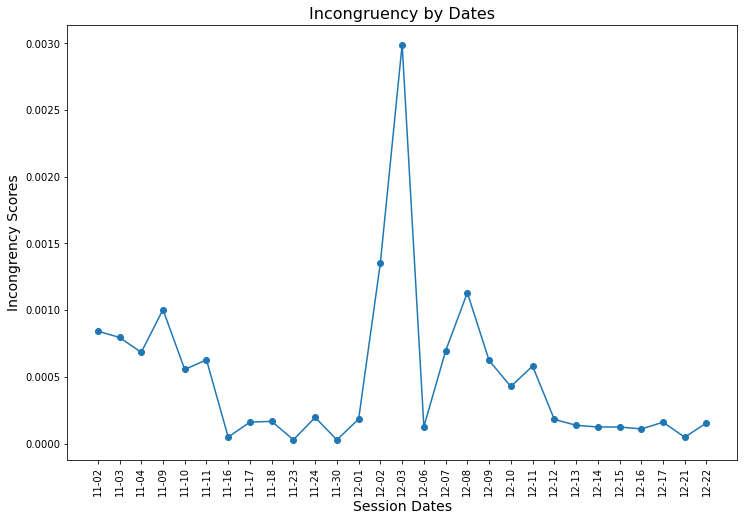

In [9]:
plt.figure(figsize=(12, 8))

plt.title("Incongruency by Dates", fontsize=16)
plt.plot(congruency_df["Date"], congruency_df["Congruency_avg"], marker="o")
plt.xticks(rotation=90)
plt.xlabel("Session Dates", fontsize=14)
plt.ylabel("Incongrency Scores", fontsize=14)
plt.show()

In [10]:
dolar = pd.read_excel("EVDS.xlsx").dropna().rename({"Tarih":"Date", "TP DK USD A YTL": "Exchange_Rate"},axis=1) # https://evds2.tcmb.gov.tr/
dolar["Date"] = pd.to_datetime(dolar["Date"], dayfirst=True)

In [11]:
df = pd.merge(pd.merge(dolar, congruency_df, left_on="Date", right_on="End_Date")[["End_Date", "Exchange_Rate"]], congruency_df, on="End_Date")[["Start_Date", "End_Date", "Date", "Congruency", "Congruency_avg", "Exchange_Rate"]]

In [12]:
scaler = StandardScaler()

df_norm = pd.concat([df["Date"],
                 pd.DataFrame(scaler.fit_transform(df[["Congruency_avg", "Exchange_Rate"]]))], axis=1).rename({0:"Congruency", 1:"Exchange_Rage"}, axis=1)

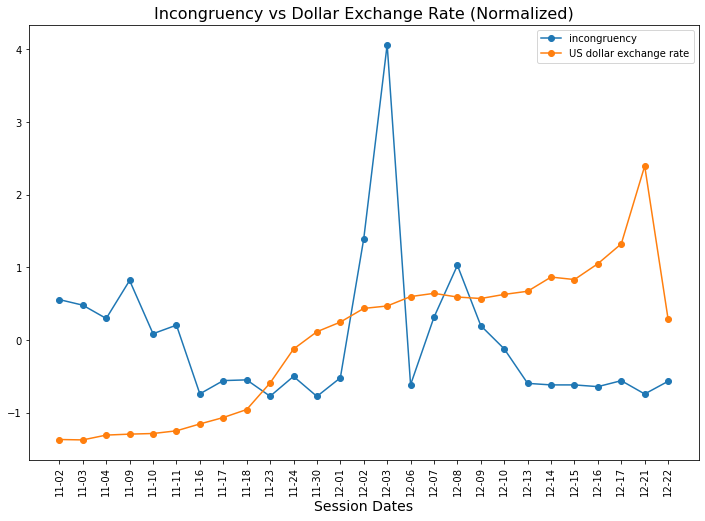

In [13]:
plt.figure(figsize=(12, 8))

plt.plot(df_norm["Date"], df_norm["Congruency"], marker="o", label="incongruency")
plt.plot(df_norm["Date"], df_norm["Exchange_Rage"], marker="o", label="US dollar exchange rate")
plt.title("Incongruency vs Dollar Exchange Rate (Normalized)", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel("Session Dates", fontsize=14)
plt.legend()

plt.show()

In [14]:
data = df[["Congruency_avg", "Exchange_Rate"]]

X = pd.DataFrame(data["Congruency_avg"])
X['constant'] = 1
y = data["Exchange_Rate"]

In [15]:
myFit = sm.OLS(y, X, missing = 'drop').fit()
myFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Exchange_Rate   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.2669
Date:                Wed, 19 Jan 2022   Prob (F-statistic):              0.610
Time:                        04:45:57   Log-Likelihood:                -58.341
No. Observations:                  27   AIC:                             120.7
Df Residuals:                      25   BIC:                             123.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Congruency_avg  -354.5468    686.336     -0.517      0.610   -1768.082    1058.989
constant          12.5912      0.543     23.209      0.000      11.474      13.709
==============================================================================
Omnibus:                        1.298   Durbin-Watson:                   0.244
Prob(Omnibus):                  0.523   Jarque-Bera (JB):                0.916
Skew:                           0.074   Prob(JB):                        0.633
Kurtosis:                       2.110   Cond. No.                     1.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Example of Word Frequency

In [16]:
def word_freq(column):
    
    words = []
    for item in column:
        for word in item.split():
            words.append(word)
            
    df = pd.concat([pd.Series(list(dict(Counter(words)).keys()), name="word"),
                    pd.Series(list(dict(Counter(words)).values()), name="counts")], axis=1)
    
    df["freq"] = df["counts"] / df["counts"].sum()
    
    return df[["word", "counts", "freq"]].sort_values("freq", ascending=False).reset_index(drop=True)

In [17]:
start_date = dates[8]
end_date = dates[9]

In [18]:
entries_df = entries[(entries["Entry_Date"] >= start_date) & (entries["Entry_Date"] < end_date)].reset_index(drop=True)
tutanak_df = tutanak[tutanak["Date"] == end_date]

freq_df = pd.merge(word_freq(entries_df["Stemmed_Entry"]),
                   word_freq(tutanak_df["Stemmed_Transcript"]),
                   on="word").rename({"freq_x": "entry_freq", "freq_y": "transcript_freq",
                                      "counts_x": "entry_count", "counts_y": "transcript_count"},axis=1)

In [19]:
## 2021-11-18 Transcript
display(freq_df[:30].sort_values("transcript_freq", ascending=False).reset_index(drop=True))

,word,entry_count,entry_freq,transcript_count,transcript_freq
0,yıl,323,0.003119,176,0.006021
1,ülke,492,0.004751,134,0.004584
2,türkiye,227,0.002192,114,0.003900
3,gün,416,0.004017,100,0.003421
4,iyi,408,0.003940,96,0.003284
5,son,376,0.003631,96,0.003284
6,yer,351,0.003389,96,0.003284
7,lira,264,0.002549,94,0.003216
8,iş,317,0.003061,82,0.002805
9,insan,414,0.003998,65,0.002224


### Word Counts

In [20]:
eksi_words = []

for entry in entries["Stemmed_Entry"]:
    for word in entry.split():
        eksi_words.append(word)

In [21]:
tutanak_words = []

for transcript in tutanak["Stemmed_Transcript"]:
    for word in transcript.split():
        tutanak_words.append(word)

In [22]:
print("Ekşi Sözlük:")
display(pd.DataFrame(Counter(eksi_words).most_common(60)).rename({0: "word", 1: "count"}, axis=1))

Ekşi Sözlük:


,word,count
0,insan,37040
1,dolar,34628
2,iyi,24138
3,yer,23183
4,ülke,23014
5,gün,22420
6,iş,22291
7,yıl,22100
8,son,21247
9,tl,18117


In [23]:
print("Debate Transcripts:")
display(pd.DataFrame(Counter(tutanak_words).most_common(60)).rename({0: "word", 1: "count"}, axis=1))

Debate Transcripts:


,word,count
0,yıl,10925
1,parti,7474
2,türkiye,4976
3,ülke,4797
4,bütçe,4422
5,kabul,4395
6,söz,4361
7,genel,4203
8,bakan,4181
9,yöne,4170
